In [2]:
import pandas as pd
import numpy as np
from scipy import signal, stats
import matplotlib.pyplot as plt
import re
from BCI2kReader import BCI2kReader as b2k
import os
import mne
import IPython
import seaborn as sns

This script is the interactive/dev version to turn the bci states into a csv comprable to the csvs I get from prolifc in order to compare their behavior.

The basic plan is to create and index to get a timestep of 50ms, loop through all of my_states, pull values for each variable of interest into a csv.

In [3]:
## prep paths

subject = 'BJH056'
orig_data_fi = '/home/brooke/knight_server/remote/WashU/data/PacmanTask/BJH056/PacmanTask/ECOG001/ECOGS001R01.dat'
raw_data_dir = f"/home/brooke/pacman/raw_data/{subject}/behave"

In [4]:
with b2k.BCI2kReader(orig_data_fi) as data: #opens a stream to the dat file
    my_signals = data.signals
    my_states = data.states
    my_params = data.parameters

In [5]:
col_names =  ['Subject',
              'Trial',
               'Time', 
               'GhostLocation',
               'UserLocation',
               'Direction',
               'Biscuit1',
               'Biscuit2',
               'Biscuit3',
               'Biscuit4',
               'Biscuit5',
               'Attack',
               'Chase',
               'Eaten',
               'Score',
               'Lives',
               'TrialType']

cleaned_game_data = pd.DataFrame(columns = col_names)

In [6]:
samples_per_500 = my_params['SamplingRate'] *.05
task_length = len(my_states['Trial_on_off'][0])
flips_per_task = int(task_length / samples_per_500)



In [7]:
for iter in range(flips_per_task):
    sample = int(range(task_length)[iter] * samples_per_500)
    cleaned_game_data.loc[iter] = [subject, my_states['Trial_on_off'][0][sample], sample,
              my_states['GhostLocation'][0][sample], my_states['UserLocation'][0][sample], my_states['Direction'][0][sample],  
              my_states['Biscuit1'][0][sample], my_states['Biscuit2'][0][sample], my_states['Biscuit3'][0][sample],
              my_states['Biscuit4'][0][sample], my_states['Biscuit5'][0][sample], my_states['Attack'][0][sample],
              my_states['Chase'][0][sample], my_states['Eaten'][0][sample], my_states['Score'][0][sample],
              my_states['Lives'][0][sample], my_states['TrialType'][0][sample]]


In [8]:
# filter to beginning of trial
first_trial = cleaned_game_data.Trial.eq(1).idxmax() - 3 # start a couple of time points ahead of first trial
last_row = cleaned_game_data.shape[0]
cleaned_game_data = cleaned_game_data.loc[first_trial:last_row]

In [9]:
# get trial count
cleaned_game_data.reset_index(inplace=True, drop = True)
last_row = cleaned_game_data.shape[0]
end_index = False
begin_index = False
cleaned_game_data = cleaned_game_data.rename(columns={'Trial': 'Trial_on_off'})  
for idx in range(4, last_row):
    if cleaned_game_data.Trial_on_off[idx] == 0 and cleaned_game_data.Trial_on_off[idx - 1] == 1:
        begin_index = idx + 1
    if cleaned_game_data.Trial_on_off[idx] == 1 and cleaned_game_data.Trial_on_off[idx - 1] == 0:
        end_index = idx - 2
    if end_index is not False:
        bad_df = cleaned_game_data.index.isin(np.arange(begin_index, end_index))
        cleaned_game_data = cleaned_game_data[~bad_df]
        end_index = False
        begin_index = False
        

In [10]:
# so now there are three zeros separating every trial, so lets count the trials!
cleaned_game_data.reset_index(inplace=True, drop = True)
last_row = cleaned_game_data.shape[0]
trial_counter = 1
cleaned_game_data['Trial'] = 0
for idx in range(4, last_row):
    cleaned_game_data.loc[idx, 'Trial'] = trial_counter
    if cleaned_game_data.Trial_on_off[idx] == 0 and cleaned_game_data.Trial_on_off[idx - 1] == 1:
        trial_counter = trial_counter + 1

cleaned_game_data = cleaned_game_data[(cleaned_game_data['Trial'] != trial_counter)] # get rid of trailing zeros

In [11]:
## test 1

cleaned_game_data

,Subject,Trial_on_off,Time,GhostLocation,UserLocation,Direction,Biscuit1,Biscuit2,Biscuit3,Biscuit4,Biscuit5,Attack,Chase,Eaten,Score,Lives,TrialType,Trial
0,BJH056,0,8500,0,0,4,0,0,0,0,0,0,0,0,0,3,0,0
1,BJH056,0,8600,0,0,4,0,0,0,0,0,0,0,0,0,3,0,0
2,BJH056,0,8700,0,0,4,0,0,0,0,0,0,0,0,0,3,0,0
3,BJH056,1,8800,48,126,4,0,0,0,0,0,0,0,0,0,3,3,0
4,BJH056,1,8900,46,126,4,0,0,0,0,0,0,0,0,0,3,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18291,BJH056,1,2695600,129,142,11,1,1,1,1,1,1,0,5,760,1,1,134
18292,BJH056,1,2695700,135,146,11,1,1,1,1,1,1,0,5,760,1,1,134
18293,BJH056,1,2695800,135,146,11,1,1,1,1,1,1,0,5,760,1,1,134
18294,BJH056,1,2695900,141,150,11,1,1,1,1,1,1,0,5,690,1,1,134


In [14]:
2696000/my_params['SamplingRate']/60

22.466666666666665

In [23]:
(1650000-1200000)/my_params['SamplingRate']/60

3.75

In [34]:
cleaned_game_data['Time_tmp'] = cleaned_game_data['Time']/my_params['SamplingRate']

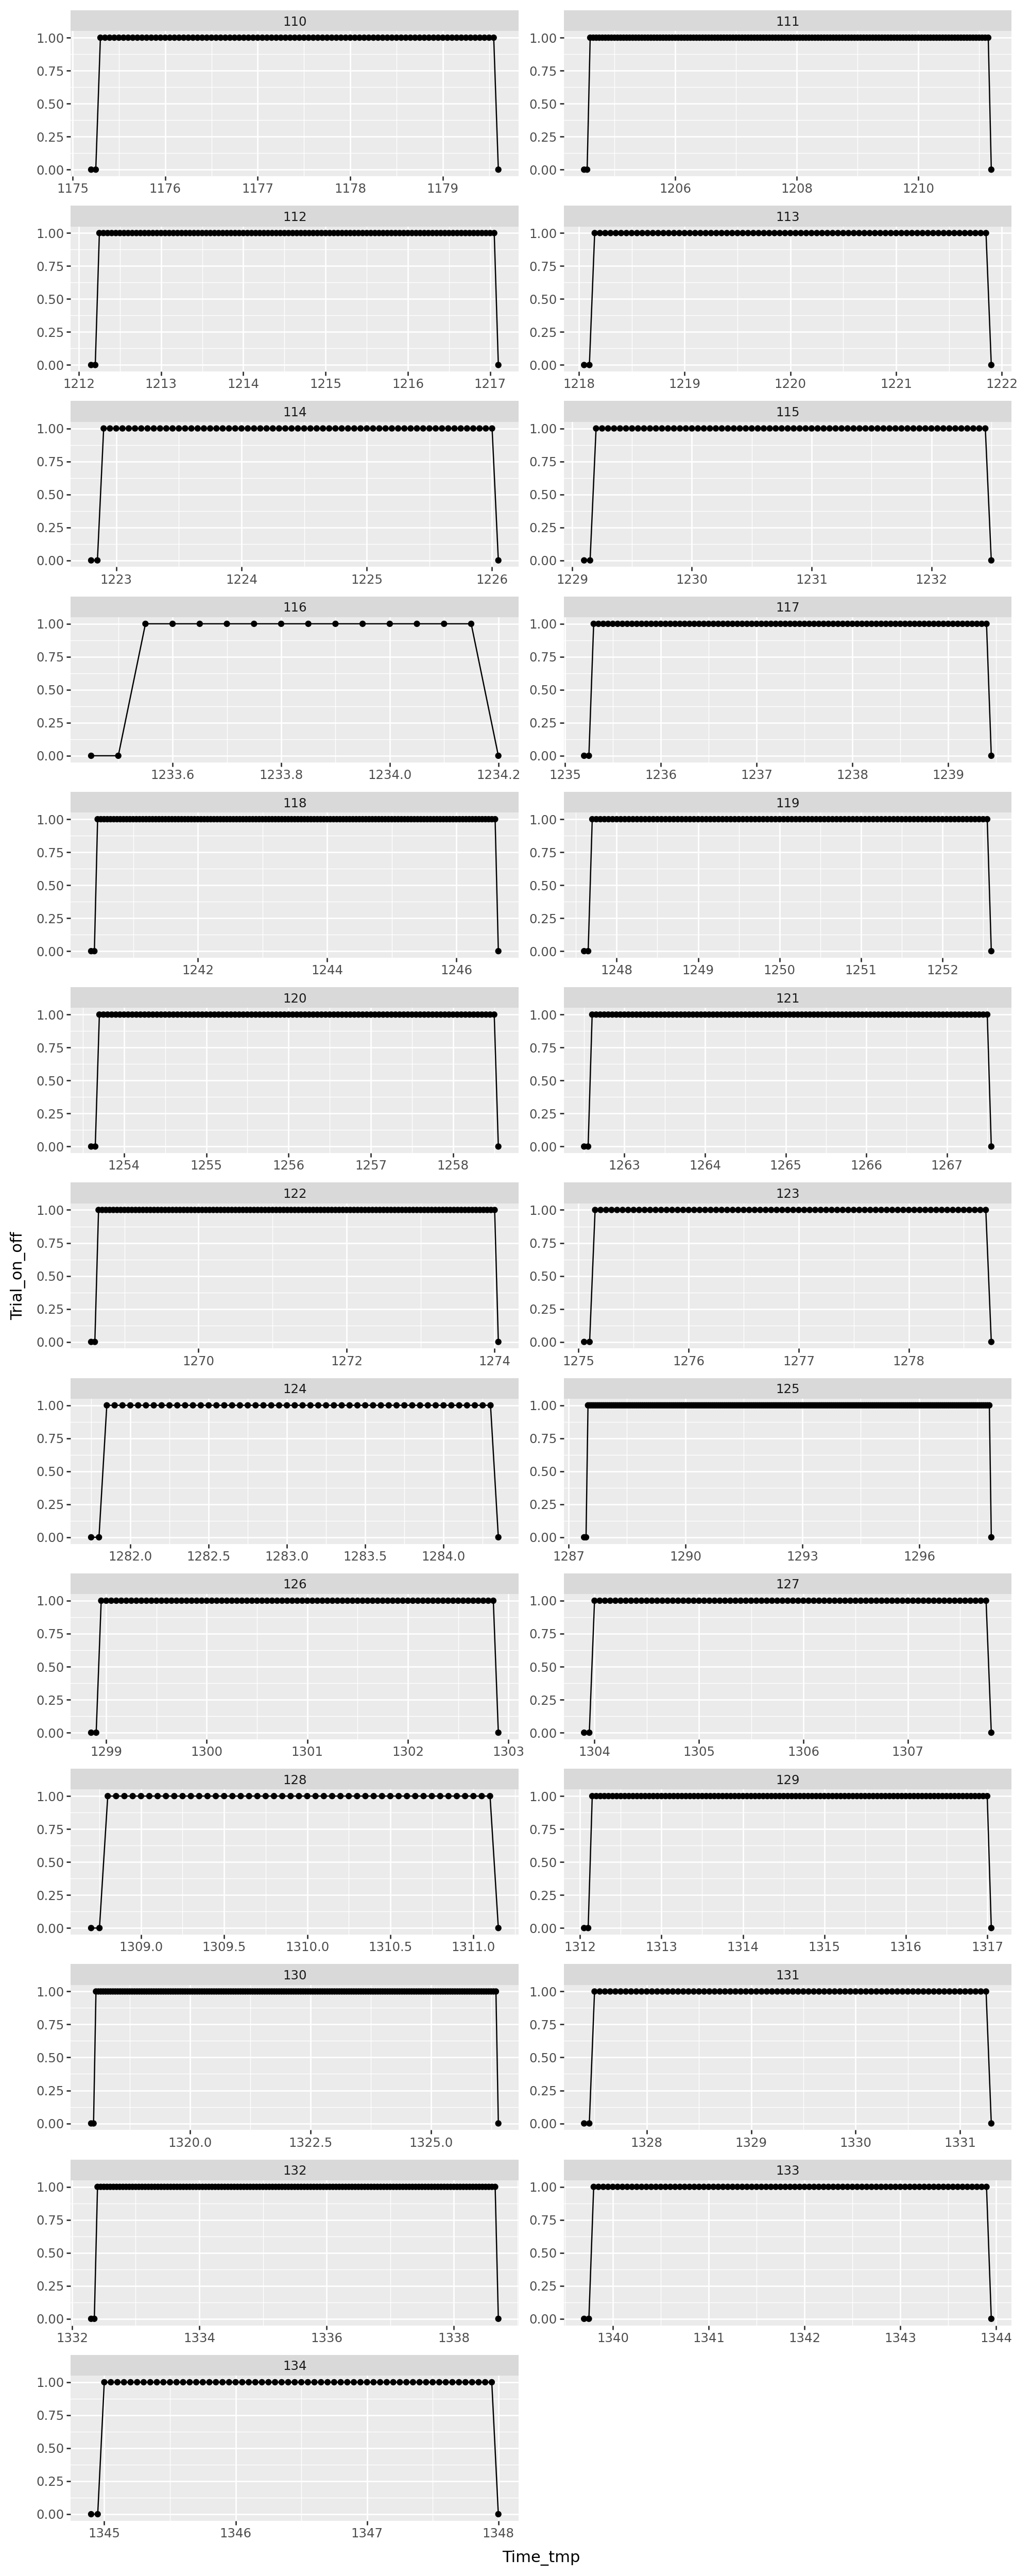

In [41]:
from plotnine import *


(ggplot(cleaned_game_data[(cleaned_game_data['Trial'] >= 110) & (cleaned_game_data['Trial'] < 210)], aes(x='Time_tmp', y='Trial_on_off')) + 
    geom_point() +
    geom_line() +
    facet_wrap('Trial', ncol = 2, scales = 'free') +
    theme(figure_size=(10, 25))) 

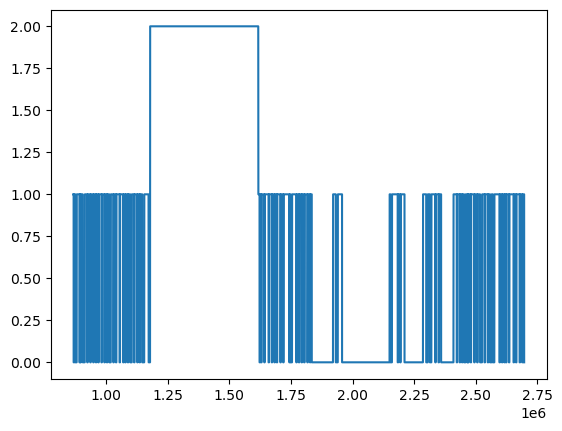

In [21]:
## test 2

plt.plot(cleaned_game_data['Time'][6000:], cleaned_game_data['Trial_on_off'][6000:])

In [58]:
## save it

cleaned_game_data.to_csv(f"{raw_data_dir}/../behave/{subject}_raw_behave.csv")